In [ ]:
from KoopmanismResponse.dynamical_systems.Models import one_dim_map
from matplotlib import pyplot as plt
import numpy as np

In [2]:
one_map = one_dim_map()
one_map.set_random_initial_condition()
one_map.M = 5* 10**5
t, x = one_map.integrate()

100%|██████████| 500000/500000 [00:02<00:00, 216262.62it/s]


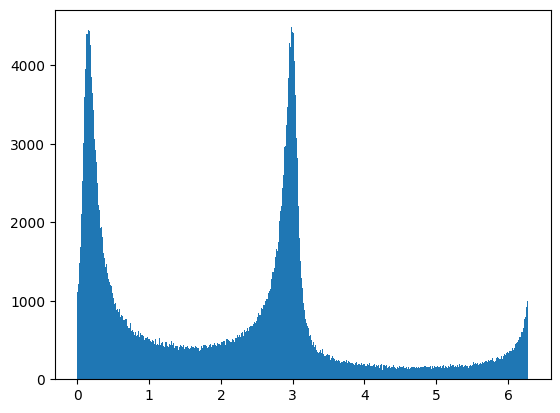

In [ ]:

L = int( np.sqrt(len(x)) ) 
plt.hist(x,bins=L);